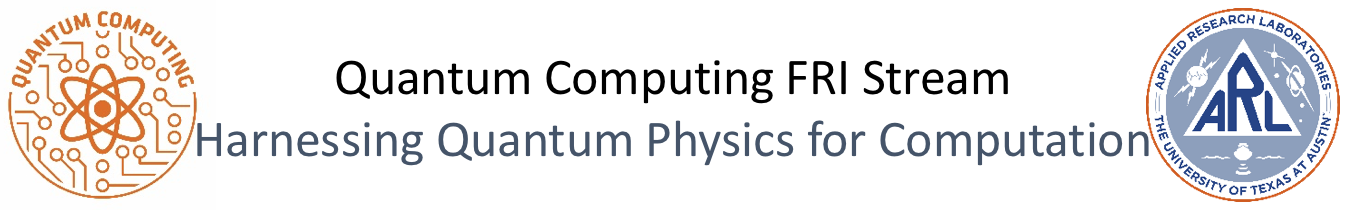

# Quantum Phase Estimation
## Lesson 9

### Installations and Imports

In [1]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [3]:
def qft(qc, n):
    for j in range(n-1, -1, -1):
        qc.h(j)
        for k in range(j-1, -1, -1):
            qc.cp(2*np.pi*2**(-(j-k+1)), k, j)

    for l in range(n//2):
        qc.swap(l, n-1-l)

In [4]:
def iqft(qc, q):

    n = len(q)

    for l in range(n//2):
        qc.swap(q[l], q[n-1-l])

    for j in range(n):
        for k in range(j):
            qc.cp(-2*np.pi*2**(-(j-k+1)), q[k], q[j])
        qc.h(q[j])

In [5]:
from qiskit.circuit.library import QFT

def built_in_qft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft')
    qc.append(gate, qubits)

    return qc

def built_in_iqft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name='iqft')
    qc.append(gate, qubits)

    return qc

## Today's Objectives

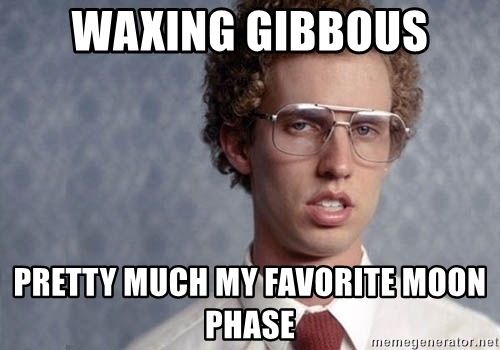

 - Discuss the phases acquired by qubits from the operation of unitaries
 - Implement an algorithm to determine the eigenvalue of a given unitary with its eigenvector

## Remember the QFT

### <font color=green> Exercise 1 </font>

Following the steps below, use qiskit to plot the Bloch sphere representations of the state $\lvert\psi\rangle = \lvert 10101 \rangle $ and then of its **Fourier Transform** $\lvert\widetilde\psi\rangle = \text{QFT}\lvert 10101 \rangle $

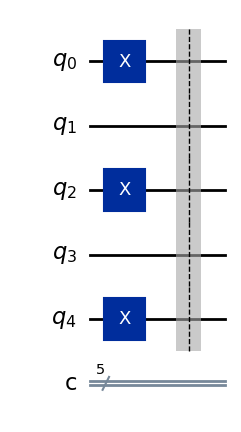

In [6]:
#Step 1, Initialize your circuit and prepare the state
#~~~Your code here
qc = QuantumCircuit(5,5)
qc.x([0,2,4])
#~~~
qc.barrier()
qc.draw('mpl')

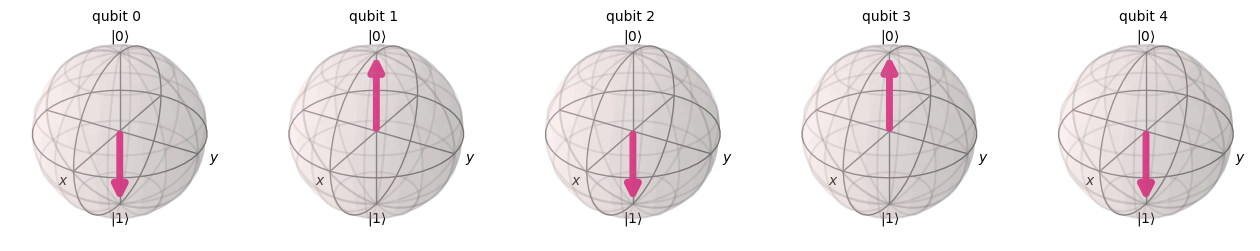

In [7]:
#Step 2, Visualize your state by executing this command
plot_bloch_multivector(Statevector.from_instruction(qc).data)

In [8]:
#Step 3, QFT your state #Hint, we've imported QFT functions from which you may choose
#~~~Your code here
qft(qc, 5)
#~~~
qc.draw()

┌───┐ ░                                                                  »
q_0: ┤ X ├─░────────────────────────────────────────────────■─────────────────»
     └───┘ ░                                                │                 »
q_1: ──────░──────────────────────────────■─────────────────┼─────────■───────»
     ┌───┐ ░                              │                 │         │       »
q_2: ┤ X ├─░────────────────■─────────────┼────────■────────┼─────────┼───────»
     └───┘ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_3: ──────░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     ┌───┐ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_4: ┤ X ├─░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
     └───┘ ░ └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                   ┌───┐   
«q_0: ──────■─────────────────■─────────────■───────┤ H ├─X─
«           │                 │       ┌───┐ │P(π/2) └───┘ │ 
«q_1: ──────┼────────■────────┼───────┤ H ├─■─────────X───┼─
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘           │   │ 
«q_2: ┤ H ├─┼────────■────────■───────────────────────┼───┼─
«     └───┘ │P(π/8)                                   │   │ 
«q_3: ──────■─────────────────────────────────────────X───┼─
«                                                         │ 
«q_4: ────────────────────────────────────────────────────X─
«                                                           
«c: 5/══════════════════════════════════════════════════════
«

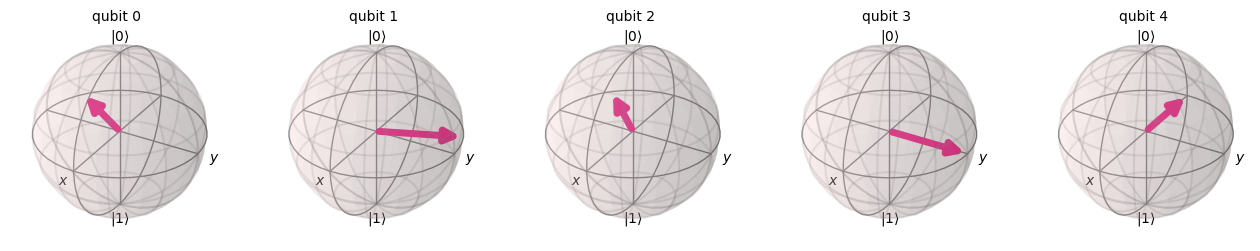

In [9]:
#Step 4, Visualize your transformed state by executing this command
plot_bloch_multivector(Statevector.from_instruction(qc).data)

#### This next cell can help matplotlib display in certain notebook environments. Try executing it if you are having issues.

In [10]:
%matplotlib

Using matplotlib backend: <object object at 0x12bc33040>


## Counting in Fourier Space

We can use the Quantum Fourier Transform (QFT) to change between the computational basis and the Fourier basis.

In the single-qubit case, this is equivalent to a Hadamard gate. But in larger dimensions, a controlled-Z rotation is applied to the qubits as well.

This Z rotation corresponds to a phase in Fourier space.

In the following cell, we count in binary from 0 to $2^{n}$ and visualize the Fourier transformed quantum state using Bloch spheres.

Note the differing rotation rates for each qubit:
At each integer step the most significant qubit rotates by $\pi$, and each less significant qubit's rotation is half that of the one before it - all the way to the least significant qubit whose rotation rate is $2\pi/2^{n}$

In [11]:
#If the images do not show, try executing the matplotlib cell above manually.
#If that doesn't work, you can manually set the index "i" rather than using the loop
n=3
form='{0:0'+str(n)+'b}'
for i in range(int(2**n)):
  bini=form.format(i)

  qc = QuantumCircuit(n)

  for j in range(n-1,-1,-1):
      if bini[j]=='1':
         qc.x(n-1-j)
  qft(qc,n)
  #built_in_qft(qc,qc.qubits,n) #If you prefer to use the built-in functions
  plot_bloch_multivector(Statevector.from_instruction(qc).data,title=bini)

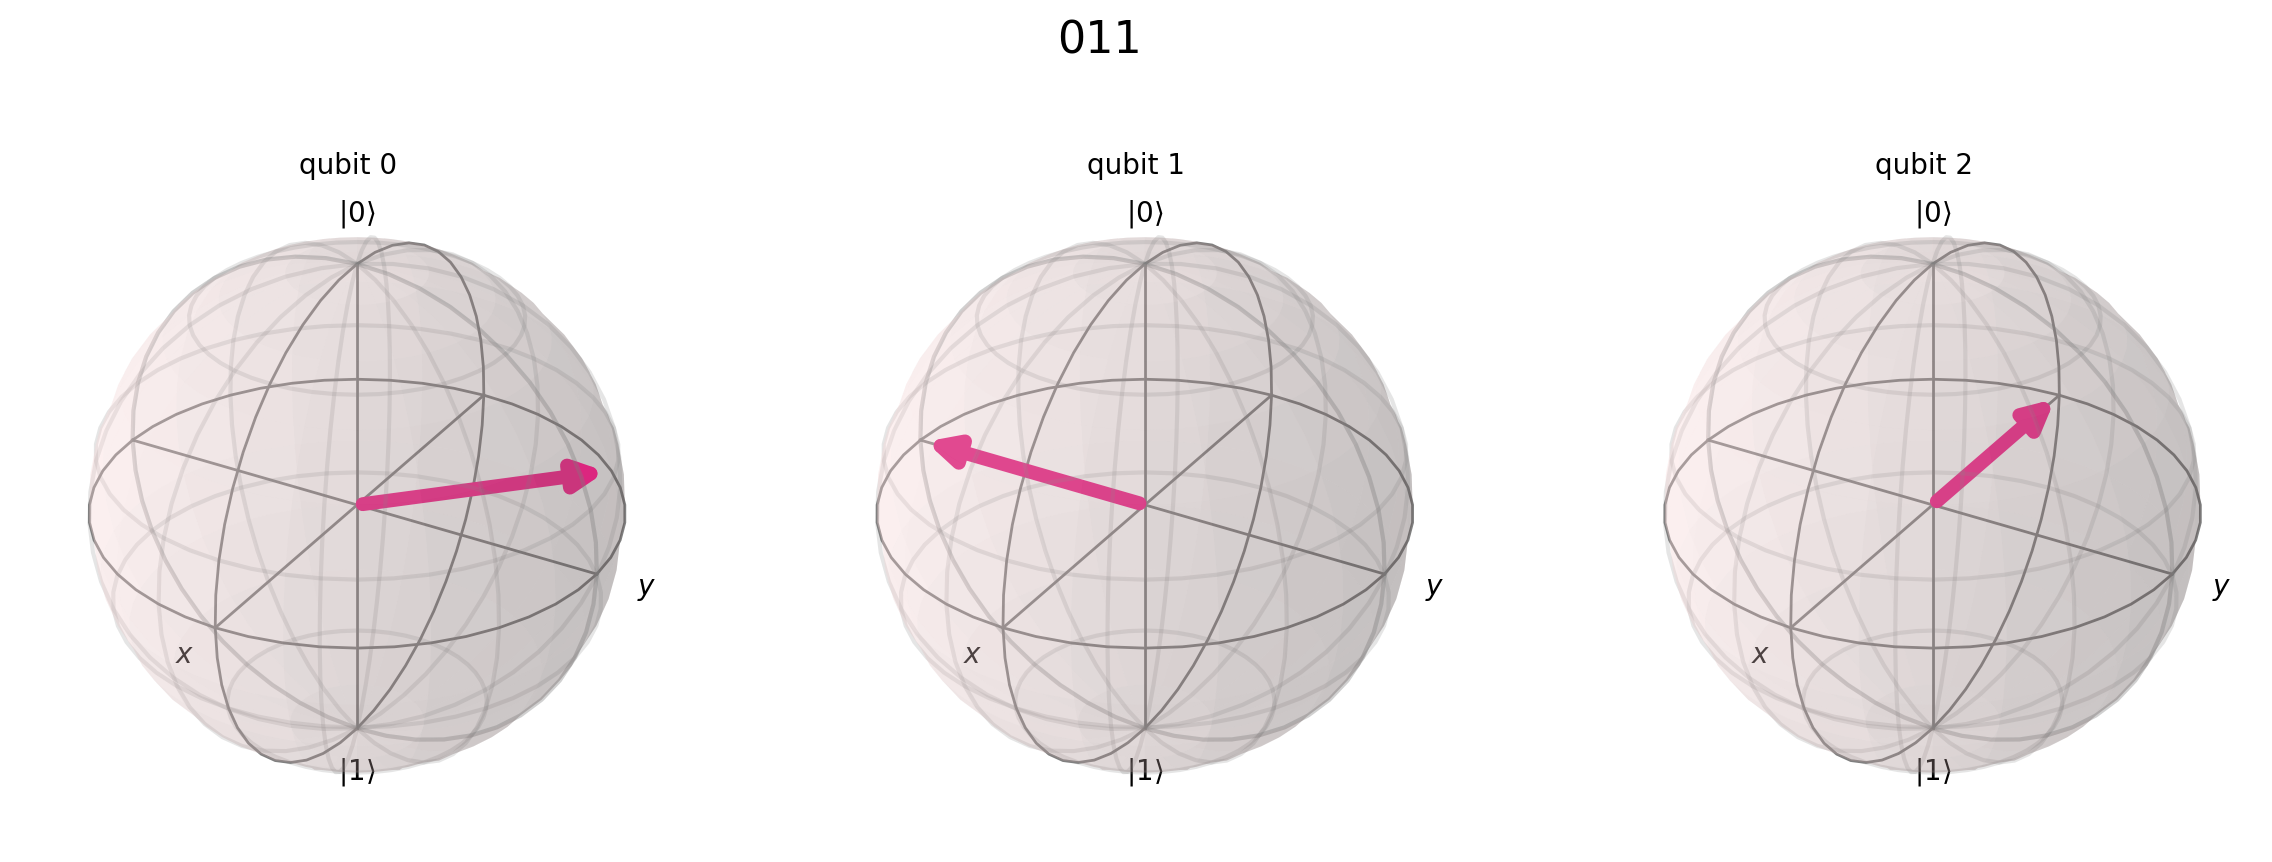

In [12]:
i=3

bini=form.format(i)

qc = QuantumCircuit(n)

for j in range(n-1,-1,-1):
    if bini[j]=='1':
        qc.x(n-1-j)
qft(qc,n)
#built_in_qft(qc,qc.qubits,n) #If you prefer to use the built-in functions
plot_bloch_multivector(Statevector.from_instruction(qc).data,title=bini)


## Phase Kickback

Given a multi-qubit state, we are familiar with the concept of a phase which can be easily factored into either of the qubits:

$$e^{i\phi}\lvert x\rangle \lvert y\rangle = e^{i\phi}\lvert x\rangle \otimes \lvert y\rangle = \lvert x\rangle \otimes e^{i\phi}\lvert y\rangle$$

Let us investigate this effect by using $\mathbf{CNOT}$ gates. As is often the case, things will be more interesting if we look at superpositions.

$$
\begin{align}
\mathbf{C}_{10}\lvert++\rangle=&\mathbf{C}_{10}\frac{\lvert00\rangle+\lvert01\rangle+\lvert10\rangle+\lvert 11\rangle}{2} =\frac{\lvert00\rangle+\lvert01\rangle+\lvert11\rangle+\lvert 10\rangle}{2}=\lvert++\rangle\\
\mathbf{C}_{10}\lvert+-\rangle =&\mathbf{C}_{10}\frac{\lvert00\rangle-\lvert01\rangle+\lvert10\rangle-\lvert 11\rangle}{2} =\frac{\lvert00\rangle-\lvert01\rangle+\lvert11\rangle-\lvert 10\rangle}{2}=\lvert\color{red}{-}\color{blue}{-}\rangle\\
\mathbf{C}_{10}\lvert-+\rangle =&\mathbf{C}_{10}\frac{\lvert00\rangle+\lvert01\rangle-\lvert10\rangle-\lvert 11\rangle}{2} =\frac{\lvert00\rangle+\lvert01\rangle-\lvert11\rangle-\lvert 10\rangle}{2}=\lvert-+\rangle\\
\mathbf{C}_{10}\lvert--\rangle =&\mathbf{C}_{10}\frac{\lvert00\rangle-\lvert01\rangle-\lvert10\rangle+\lvert 11\rangle}{2} =\frac{\lvert00\rangle-\lvert01\rangle-\lvert11\rangle+\lvert 10\rangle}{2}=\lvert\color{red}{+}\color{blue}{-}\rangle\\
\end{align}
$$



In these examples, we see a net change in the state only when the target qubit is in the $\lvert-\rangle$ state. But interestingly, the change manifests in the __control__ bit!

Look more closely at the $\lvert+-\rangle$ example.

$$\begin{align}
\mathbf{C}_{10}\lvert+-\rangle =&\mathbf{C}_{10}\left(\lvert0\rangle\frac{\lvert0\rangle-\lvert1\rangle}{\sqrt{2}}+\lvert1\rangle\frac{\lvert0\rangle-\lvert1\rangle}{\sqrt{2}} \right)/\sqrt{2} \\
=&\left(\lvert0\rangle\frac{\lvert0\rangle-\lvert1\rangle}{\sqrt{2}}+\lvert1\rangle\frac{\color{blue}{\lvert1\rangle}-\color{blue}{\lvert0\rangle}}{\sqrt{2}} \right)/\sqrt{2} \\
=&\left(\lvert0\rangle\frac{\lvert0\rangle-\lvert1\rangle}{\sqrt{2}}+\color{red}{-}\lvert1\rangle\frac{\lvert0\rangle\color{blue}{-}\lvert1\rangle}{\sqrt{2}} \right)/\sqrt{2} \\
=&\lvert\color{red}{-}\color{blue}{-}\rangle
\end{align}
$$

$\text{When the target qubit is in the }\lvert-\rangle \text{ state, the }e^{i\pi}=-1 \text{ phase on the target qubit can be factored into the }\lvert 1 \rangle \text{ term of the control qubit!}$

## The Phase Problem

$\text{Suppose we are given some unitary operator }\mathbf{U} \text{ and its eigenvector }\lvert v\rangle \text{ such that}$

$$\mathbf{U}\lvert v\rangle = e^{i 2\pi \phi}\lvert v\rangle$$

How can we determine the value of $\phi$?

For example:

$$\mathbf{U}=\begin{pmatrix} 1 & 0 \\ 0 & e^{i2\pi\phi} \end{pmatrix} \qquad\qquad \lvert v\rangle = \begin{bmatrix} 0 \\ 1 \end{bmatrix} \qquad\qquad \mathbf{U}\lvert v\rangle = e^{i 2\pi \phi}\lvert v\rangle$$

\\

Can we measure this phase?

#### Spoiler

Often, the task of measuring a phase like this seems impossible. We know, after all, that a global phase is unmeasurable.

Relative phase, however, is measureable in the appropriate basis!

### Quantum Phase Estimation Algorithm

Part of the key to measuring the phase applied by an operator $\mathbf{U}$ is to promote it to a controlled operation.

$\text{We will estimate the phase }\phi\in\left[0,1\right) \text{ as a binary fraction }\frac{\phi_{1}}{2^{1}}+\frac{\phi_{2}}{2^{2}}+\cdots+\frac{\phi_{n}}{2^{n}}$

$1. \text{ Begin with an }n\text{-qubit input register }\lvert 0\cdots0\rangle \text{ and an output register }\lvert v \rangle$

$2. \text{ Apply Hadamards to the input register to create a superposition}$

$3. \text{ For }k=0,\dots,n-1
\text{ apply a controlled }\mathbf{U}^{2^{k}} \text{ to }\lvert v\rangle,\text{ using input qubit }k\text{ as the control}$

$4. \text{ Apply an inverse QFT to the input register. }\text{ The quantum registers should now be in state }\lvert \phi_{1}\cdots\phi_{n}\rangle\lvert v\rangle$

$5.\text{ Measure the input register.}$

### <font color=green>Exercise 2</font>

In the following cell, implement the phase estimation algorithm. In order to test it, execute the cells in the "Testing" section below.

In [13]:
def phaseEstimation(qc, qx, qv, phi):
    # qc is a quantum circuit
    # qx is an n-qubit quantum registers within qc
    # qv is a single-qubit register within qc
    # phi in [0,1) is the true phase parameter
    qc.h(qx)
    for k in range(len(qx)):
        qc.cp((2*np.pi*phi)*(2**k),qx[k], qv )
    iqft(qc, qx)
    return qcx

    
       

    #Note that the provided iqft takes in a quantum register as an argument
    ##rather than a number of qubits
    raise NotImplementedError

#### Testing

In [14]:
def makeIntegerCircuit(n, x, m=0, y=None, nocbits=False):

    # define base quantum and classical registers
    q = QuantumRegister(n+m)
    if nocbits:
        c = ClassicalRegister(1)
    else:
        c = ClassicalRegister(n+m)
    qc = QuantumCircuit(q, c)

    # turn base quantum registers into separate lists
    if (y is None):
        qx = [q[i] for i in range(n)]
    else:
        qy = [q[i] for i in range(m)]
        qx = [q[i] for i in range(m,m+n)]

    # encode integers into quantum registers
    bits = np.binary_repr(x, width=n)
    for i in range(n):
        if bits[n-1-i] == '1':
            qc.x(qx[i])
    if y is not None:
        bits = np.binary_repr(y, width=m)
        for i in range(m):
            if bits[m-1-i] == '1':
                qc.x(qy[i])

    # return final circuit and registers
    if (y is None):
        return qc, c, qx
    else:
        return qc, c, qx, qy



def measureCircuit(qc, c, qx, qy=None):

    # determine number of qubits in each register
    n = len(qx)
    if qy is not None:
        m = len(qy)
    else:
        m = 0

    # apply measurement gates
    if qy is None:
        for i in range(n):
            qc.measure(qx[i], c[i])
    else:
        for j in range(m):
            qc.measure(qy[j], c[j])
        for i in range(n):
            qc.measure(qx[i], c[m+i])

    # execute quantum circuit
    backend=Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1024)
    data = job.result().get_counts(qc)
    # print(data)

    # extract the integer values of the input register, x, and output register, y
    out = list(data.keys())[0]
    y = 0
    for i in range(m):
        if out[n+m-1-i] == '1':
            y += 2**i
    x = 0
    for i in range(m,n+m):
        if out[n+m-1-i] == '1':
            x += 2**(i-m)

    if qy is None:
        return x
    else:
        return x, y



In [15]:
def test(fun):

    # pick a random phase
    n = np.random.randint(1,10)
    x = np.random.randint(2**n)
    bits = np.binary_repr(x,n)
    phi = 0
    for k in range(n):
        if bits[k] == '1':
            phi += 1/2**(k+1)
    print("phi = "+str(phi)+" (true)")

    # apply the phase estimation algorithm
    qc, c, qx, qv = makeIntegerCircuit(n, 0, 1, 1)
    fun(qc, qx, qv, phi)
    x, y = measureCircuit(qc, c, qx, qv)
    bits = np.binary_repr(x,n)
    phi_est = 0
    for k in range(n):
        if bits[k] == '1':
            phi_est += 1/2**(k+1)
    print("phi = "+str(phi_est)+" (estimated)")

In [16]:
test(phaseEstimation)

phi = 0.271484375 (true)
phi = 0.271484375 (estimated)


: 

In [2]:
from sympy import Symbol, I, Abs

# Define a complex symbol
z = Symbol('z')

# Create a complex expression
complex_expr = 3 + 4*I

# Calculate the magnitude
magnitude = abs(complex_expr)

print(magnitude)

5


## Phase Estimation - How does it work?

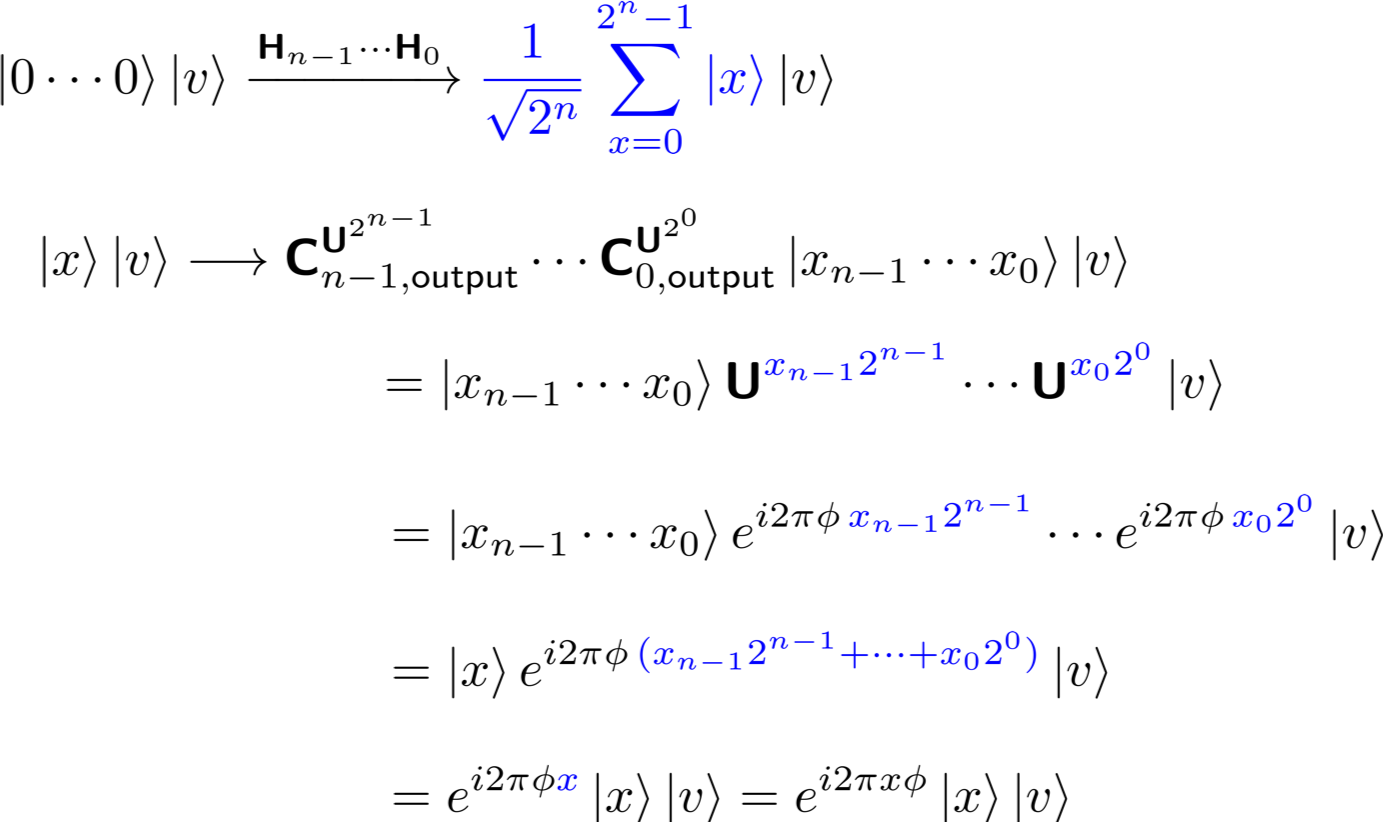

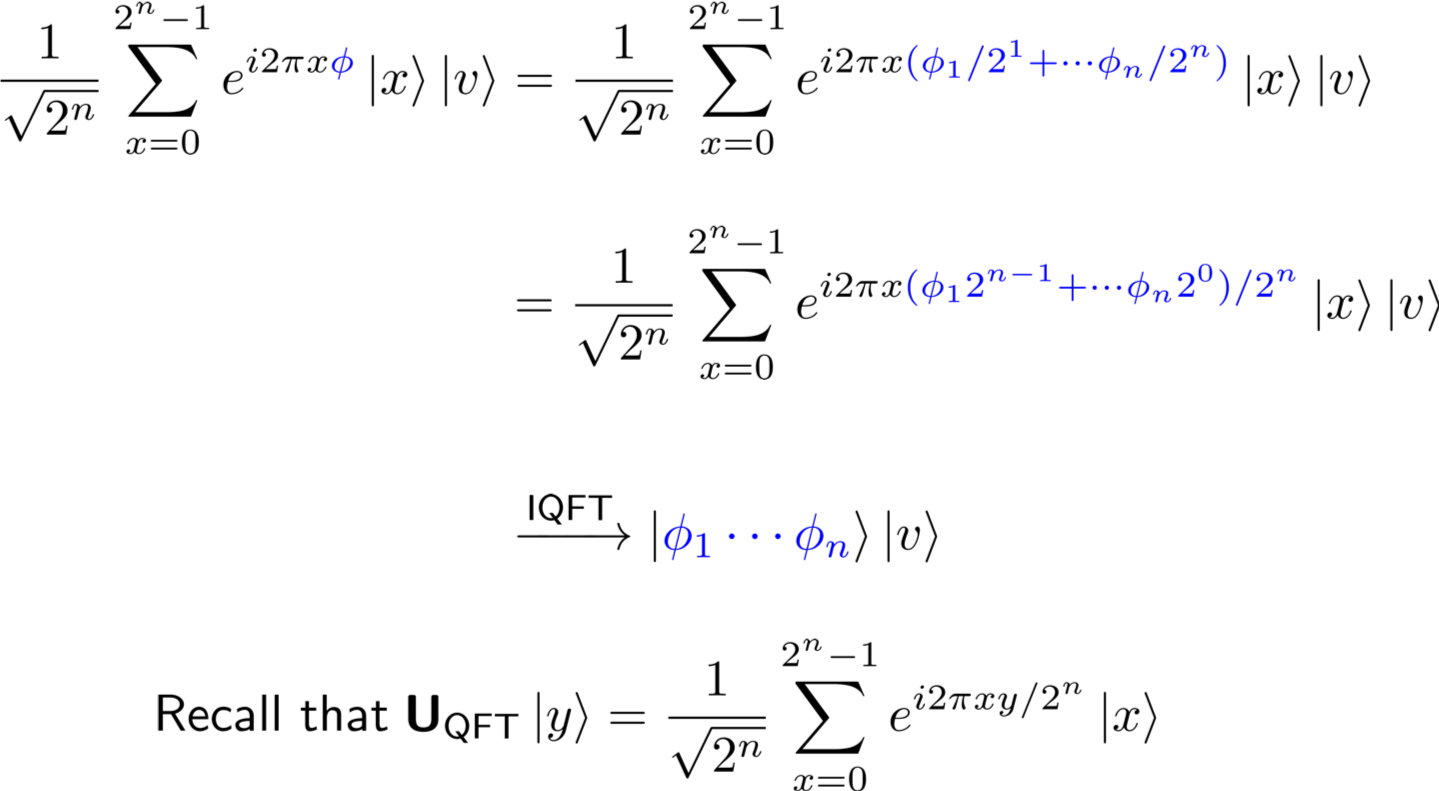